In [3]:
import sys
sys.path.insert(0, '/home/workspace/mm_analysis')

from py_util import *

hdir = '/home/workspace/'
wdir = hdir + "/mm_analysis/EXP-01244"
pltdir = wdir + "/plots/"
srldir = wdir + "/objects/"

raw_adata = sc.read_h5ad(srldir + 'raw_adata.h5ad')

In [4]:
def process_adata(adata):
    
    # Filtering out mitochondrial and Ig genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ig"] = adata.var_names.str.contains("^IG")
    
    adata = adata[:, (adata.var['mt'] == False) & (adata.var['ig'] == False)]

    # Applying scanpy processing pipeline
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=["mt", "ig"],
        inplace=True,
        log1p=True
    )

    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(
        adata, 
        n_top_genes=2000, 
        batch_key="sample"
    )
    sc.tl.pca(adata)

    X = adata.obsm['X_pca'].astype(np.float64)

    harmony_out = hm.run_harmony(X, adata.obs, 'sample_type')

    adata.obsm['X_pca'] = harmony_out.Z_corr.T

    sc.pp.neighbors(adata)
    sc.tl.draw_graph(adata)
    sc.tl.umap(adata)

    res_range = np.round(np.arange(0, 2.2, 0.2), 1)
    
    for res in res_range:
        sc.tl.leiden(
            adata, 
            flavor="igraph",
            key_added=f"leiden_{str(res).replace('.', '_')}",
            n_iterations=2,
            resolution=res
        )
    
    # sc.tl.paga(adata, groups='leiden')
    # sc.tl.rank_genes_groups(
    #     adata, 
    #     groupby="leiden", 
    #     method="wilcoxon"
    # )

    # sc.tl.diffmap(adata)

    return adata

In [9]:
raw_adatas = {
    name: raw_adata[raw_adata.obs['sample_type'] == name] for name in list(raw_adata.obs['sample_type'].unique())
}

adatas = {
    name: process_adata(data).copy() for name, data in raw_adatas.items()
}

sample_dict = {
    'week2': 'Week 2',
    'week3': 'Week 3',
    'week4': 'Week 4',
    'bm': 'BMMC Start Sample',
    'msc': 'MSC Start Sample'
}

adatas.obs['names'] = concat.obs['sample_type'].replace(sample_dict)

2025-01-22 19:49:00,566 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-01-22 19:49:01,087 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-01-22 19:49:01,163 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-01-22 19:49:01,373 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-01-22 19:49:01,594 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2025-01-22 19:49:01,807 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2025-01-22 19:49:02,009 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2025-01-22 19:49:02,208 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2025-01-22 19:49:02,338 - harmonypy - INFO - Iteration 7 of 10
Iteration 7 of 10
2025-01-22 19:49:02,406 - harmonypy - INFO - Converged after 7 iterations
Converged after 7 iterations
/home/workspace/environment/tissdiss_py_env/lib/python3.9/

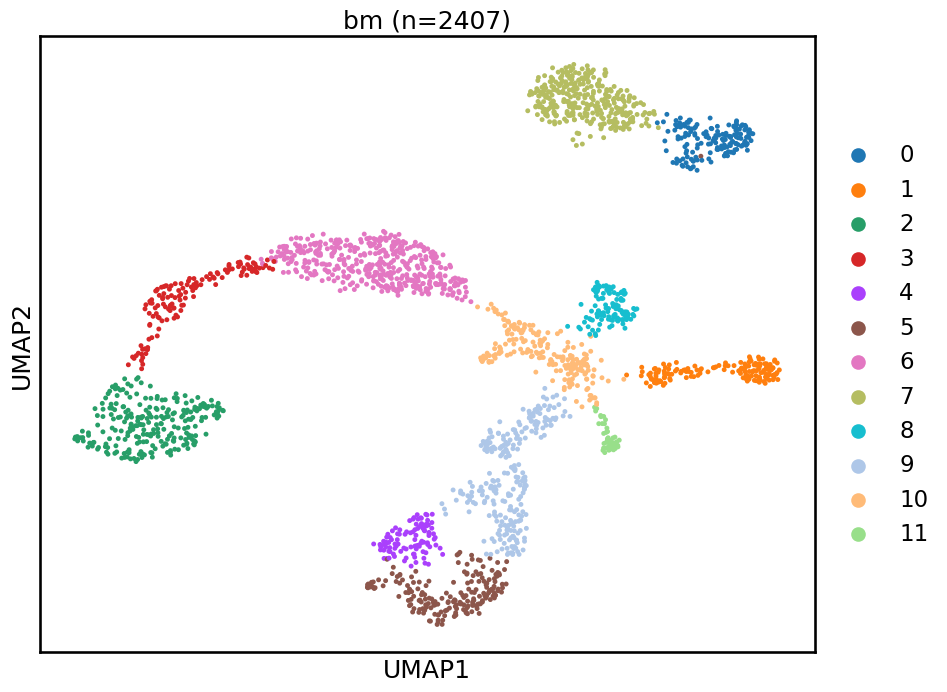

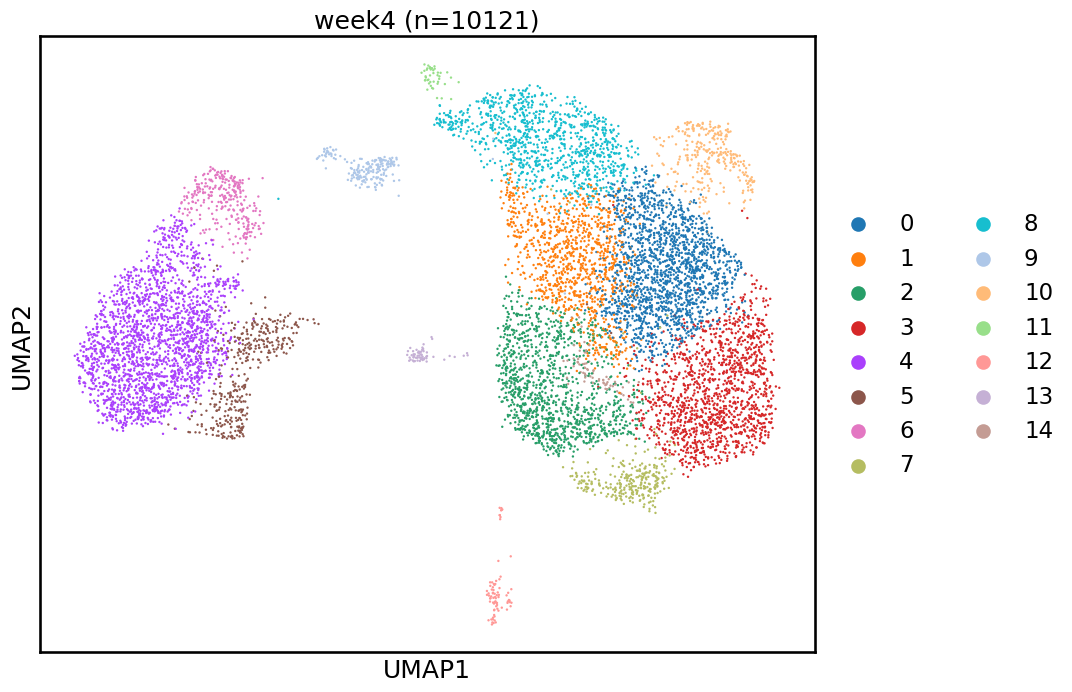

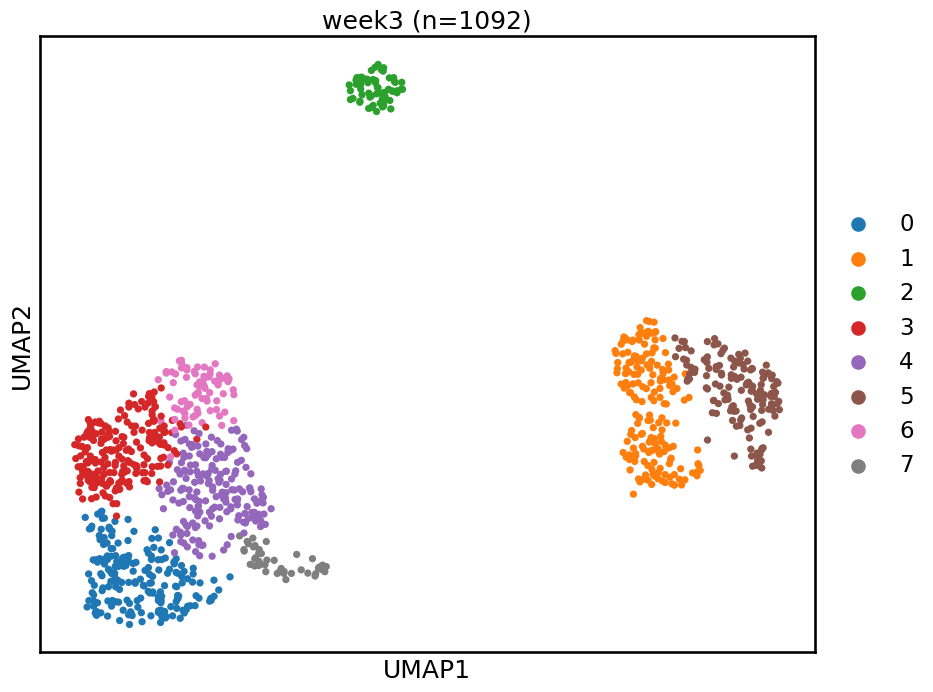

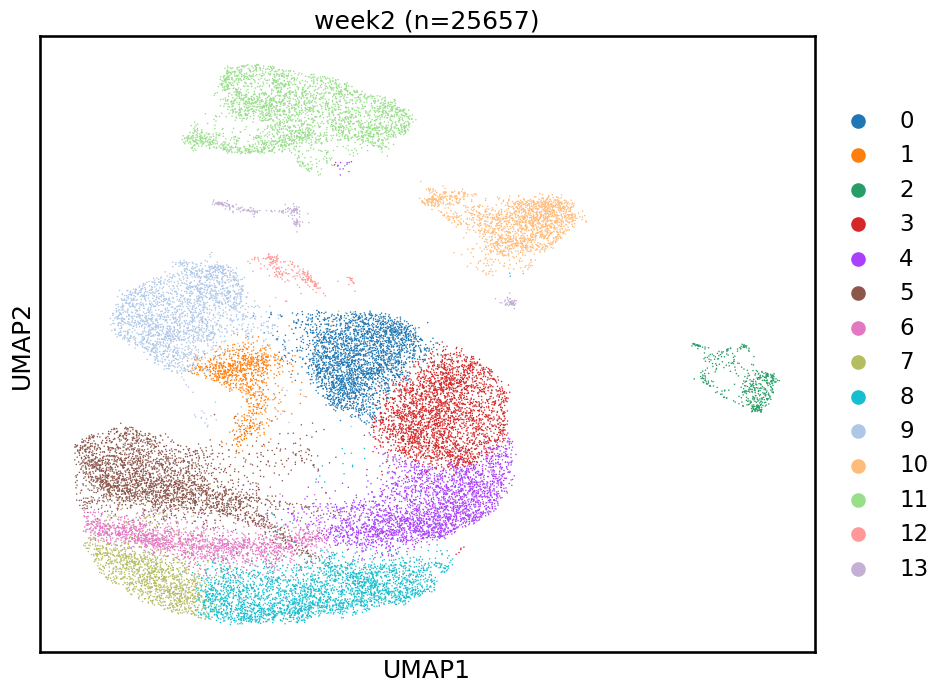

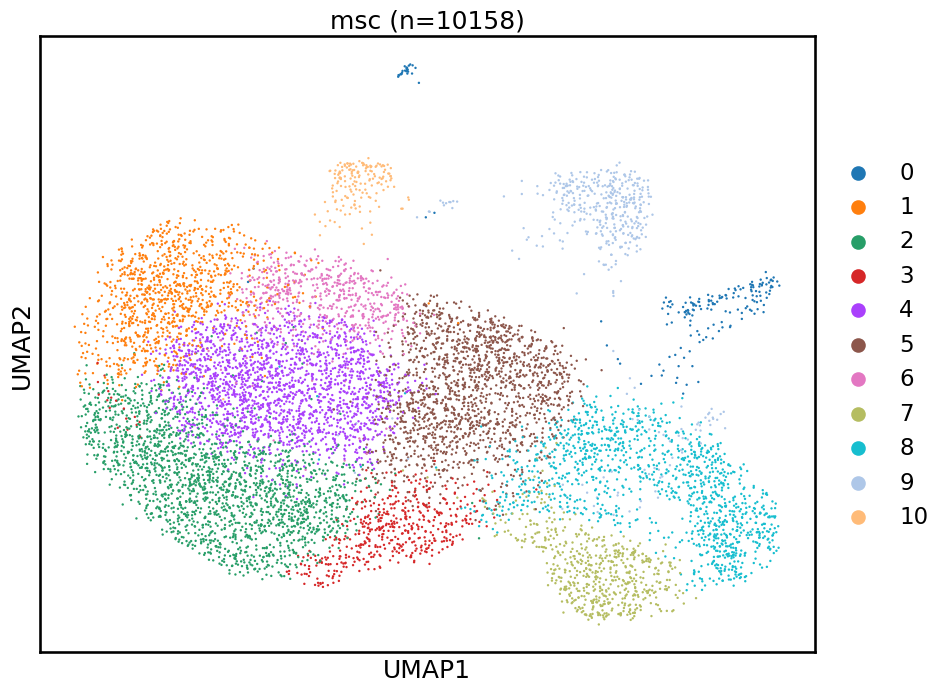

In [14]:
for name, data in adatas.items():
    fig, ax = plt.subplots(figsize=(10, 8))
    ncells = len(data)
    sc.pl.umap(
        data,
        color='leiden_0_6',
        show=False,
        ax=ax,
        title=f'{name} (n={ncells})'
    )